# Sentiment Analysis - TripAdvisor

## Introduction: Sentiment Analysis

![image](https://www.kdnuggets.com/images/sentiment-fig-1-689.jpg)

Sentiment analysis is the process of detecting positive or negative sentiment in text. It’s often used by businesses to detect sentiment in social data, gauge brand reputation, and understand customers.

### Why Is Sentiment Analysis Important?
Sentiment analysis is extremely important because it helps businesses quickly understand the overall opinions of their customers. By automatically sorting the sentiment behind reviews, social media conversations, and more, you can make faster and more accurate decisions.

It’s estimated that 90% of the world’s data is unstructured, in other words it’s unorganized. Huge volumes of unstructured business data are created every day: emails, support tickets, chats, social media conversations, surveys, articles, documents, etc). But it’s hard to analyze for sentiment in a timely and efficient manner.

### Some Applications of Sentiment Analysis
The applications of sentiment analysis are endless and can be applied to any industry, from finance and retail to hospitality and technology. Below, we’ve listed some of the most popular ways that sentiment analysis is being used in business:

1. Social Media Monitoring
1. Brand Monitoring
1. Voice of customer (VoC)
1. Customer Service
1. Market Research

### Pipeline of Sentiment Analysis

![pipeline](https://cdn-images-1.medium.com/max/361/0*ga5rNPmVYBsCm-lz.)

## 0. Setup

In [1]:
# General packages
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
# import seaborn as sns

# NLP packages
import re
import nltk

# Modelling packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_

from src.tripadvisor_dataset import(
    stopwords_removal,
    clean_data,
    wordcloud_generator,
    SentimentDataset,
    collate
)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## 1. Dataset

### Load Data

In [2]:
data_root = os.path.join(os.path.abspath(os.getcwd()), "data", "tripadvisor_hotel_reviews.csv")
# print(data_root)
data = pd.read_csv(data_root)
data.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [3]:
data.shape

(20491, 2)

Check for null values:

In [4]:
# checking for null values
data.isnull().sum()

Review    0
Rating    0
dtype: int64

### Analysing the Data

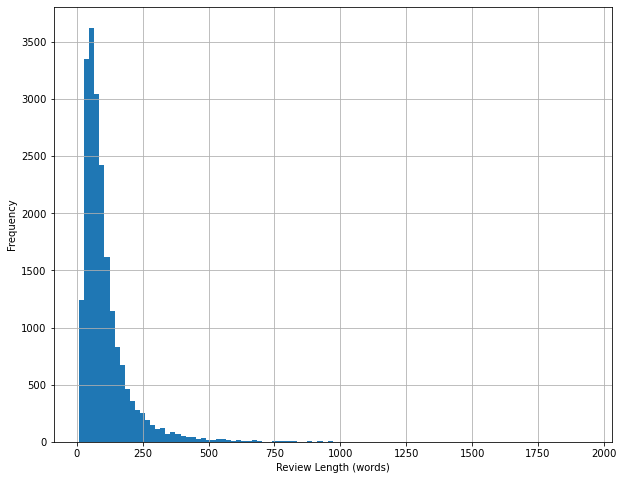

In [5]:
## Getting the number of words by splitting them by a space
words_per_review = data.Review.apply(lambda x: len(x.split(" ")))
words_per_review.hist(bins = 100)
plt.xlabel('Review Length (words)')
plt.ylabel('Frequency')
plt.show()

We can observe that the dataset is positively skewed.

In [6]:
print('Average words:', words_per_review.mean())
print('Skewness:', words_per_review.skew())

Average words: 106.3750427016739
Skewness: 4.495935249170961


In [7]:
percent_val = 100 * data['Rating'].value_counts(normalize=True)
percent_val

5    44.185252
4    29.471475
3    10.658338
2     8.750183
1     6.934752
Name: Rating, dtype: float64

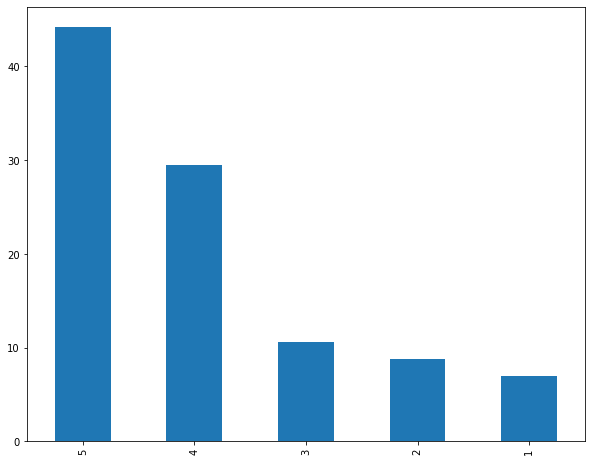

In [8]:
percent_val.plot.bar()
plt.show()

# sns.countplot(data=data,x='Rating', palette="Set3")

### Wordcloud of most common words

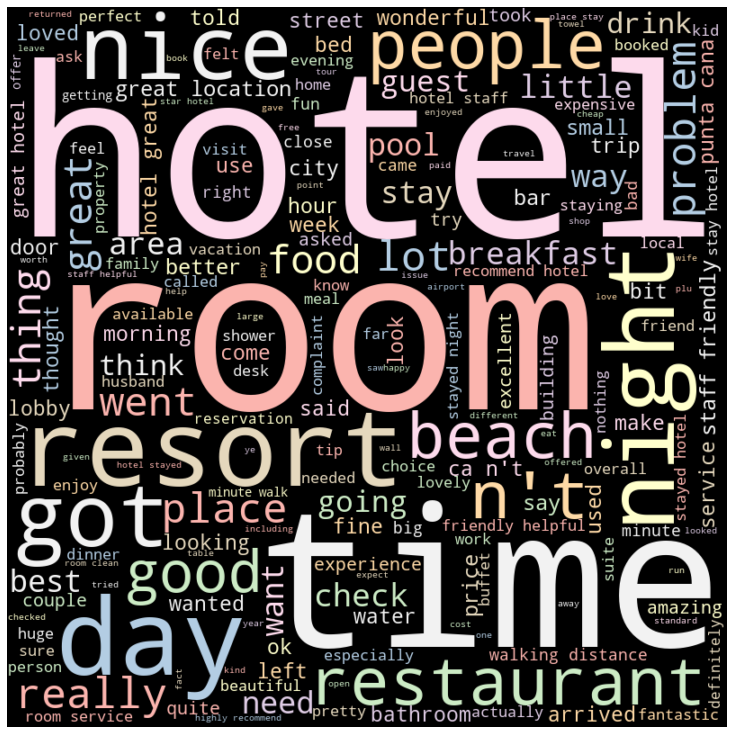

In [18]:
wordcloud_generator(data['Review'])

### Preprocessing Data

#### Convert words to lowercase and remove special characters:
* Remove the Hashtags from the text
* Remove the links from the text
* Remove the twitter handlers
* Remove the Special characters from the text 
* Substitute the multiple spaces with single spaces
* Remove all the single characters in the text


In [10]:
data['Review_preprocessed'] = data['Review'].copy()

clean_data(data,'Review_preprocessed')

print("- Old Review -")
print(data['Review'][4])
print("\n- New Review -")
print(data['Review_preprocessed'][4])

- Old Review -
great stay great stay, went seahawk game awesome, downfall view building did n't complain, room huge staff helpful, booked hotels website seahawk package, no charge parking got voucher taxi, problem taxi driver did n't want accept voucher barely spoke english, funny thing speak arabic called started making comments girlfriend cell phone buddy, took second realize just said fact speak language face priceless, ass told, said large city, told head doorman issue called cab company promply answer did n't, apologized offered pay taxi, bucks 2 miles stadium, game plan taxi return going humpin, great walk did n't mind, right christmas wonderful lights, homeless stowed away building entrances leave, police presence not greatest area stadium, activities 7 blocks pike street waterfront great coffee shops way, hotel mantained foyer awesome, wine tasting available evening, best dog, taking st. bernard time family, safes hotel located service desk room, bathroom huge jetted tub huge, 

#### Tokenize data and remove stopwords and high/low-frequency words

In [20]:
print('Available languages for NLTK v.3.5: ')
print(nltk.corpus.stopwords.fileids())

eng_stopwords = nltk.corpus.stopwords.words('english')
print(f'\nExample stopwords: {eng_stopwords[:20]} ...')

Available languages for NLTK v.3.5: 
['arabic', 'azerbaijani', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'greek', 'hungarian', 'indonesian', 'italian', 'kazakh', 'nepali', 'norwegian', 'portuguese', 'romanian', 'russian', 'slovene', 'spanish', 'swedish', 'tajik', 'turkish']

Example stopwords: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his'] ...


In [12]:
without_stop_words = []
stopword = []
sentence = data['Review_preprocessed'][4]
words = nltk.word_tokenize(sentence)

for word in words:
    if word in eng_stopwords:
        stopword.append(word)
    else:
        without_stop_words.append(word)

print('-- Original Sentence --\n', sentence)
print('\n-- Stopwords in the sentence --\n', stopword)
print('\n-- Non-stopwords in the sentence --\n', without_stop_words)

-- Original Sentence --
 great stay great stay went seahawk game awesome downfall view building did t complain room huge staff helpful booked hotels website seahawk package no charge parking got voucher taxi problem taxi driver did t want accept voucher barely spoke english funny thing speak arabic called started making comments girlfriend cell phone buddy took second realize just said fact speak language face priceless ass told said large city told head doorman issue called cab company promply answer did t apologized offered pay taxi bucks 2 miles stadium game plan taxi return going humpin great walk did t mind right christmas wonderful lights homeless stowed away building entrances leave police presence not greatest area stadium activities 7 blocks pike street waterfront great coffee shops way hotel mantained foyer awesome wine tasting available evening best dog taking st bernard time family safes hotel located service desk room bathroom huge jetted tub huge funny house keeping walke

In [13]:
data['Review_preprocessed'] = data['Review_preprocessed'].apply(lambda row: stopwords_removal(eng_stopwords, row))
data[['Review','Review_preprocessed']]

,Review,Review_preprocessed
0,nice hotel expensive parking got good deal sta...,"[nice, hotel, expensive, parking, got, good, d..."
1,ok nothing special charge diamond member hilto...,"[ok, nothing, special, charge, diamond, member..."
2,nice rooms not 4* experience hotel monaco seat...,"[nice, rooms, 4, experience, hotel, monaco, se..."
3,"unique, great stay, wonderful time hotel monac...","[unique, great, stay, wonderful, time, hotel, ..."
4,"great stay great stay, went seahawk game aweso...","[great, stay, great, stay, went, seahawk, game..."
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...","[best, kept, secret, 3rd, time, staying, charm..."
20487,great location price view hotel great quick pl...,"[great, location, price, view, hotel, great, q..."
20488,"ok just looks nice modern outside, desk staff ...","[ok, looks, nice, modern, outside, desk, staff..."
20489,hotel theft ruined vacation hotel opened sept ...,"[hotel, theft, ruined, vacation, hotel, opened..."


Stemming/lemmatization